In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
np.random.seed(42)

In [3]:
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
# mnist

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

X = mnist.train.images # Returns np.array
y = np.asarray(mnist.train.labels, dtype=np.int32)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
X.shape

(55000, 784)

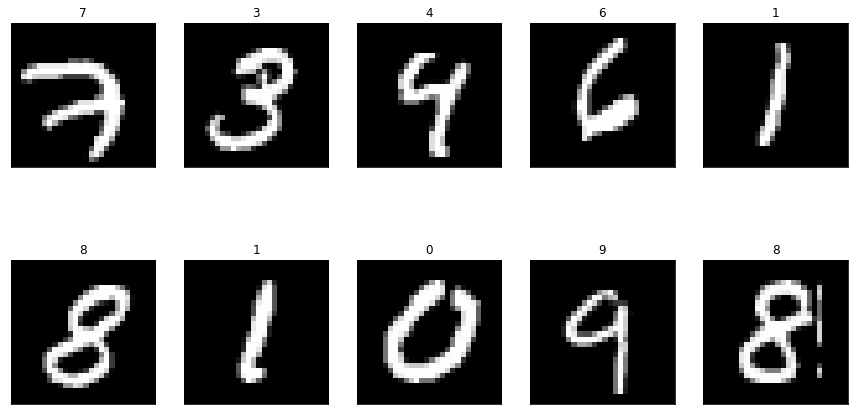

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y, X, axes.ravel()):
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gist_gray)
    ax.set_title(target)
plt.show() 

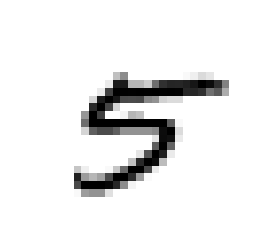

In [8]:
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

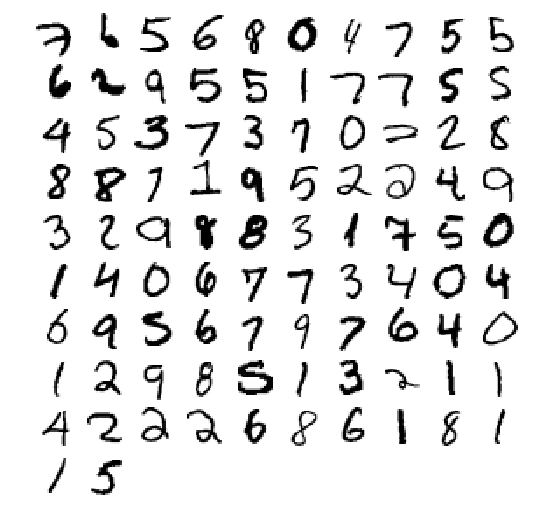

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

P0każmy przykładem binarnego klasyfikatora, zdolnego rozróżnić tylko dwie klasy:
 * 5 
  nie-5. 
  
Stwórzmy docelowe zboty (trin/test) dla tego zadania klasyfikacji:

In [11]:
X_train = mnist.train.images 
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

In [12]:
print(X_train.shape)
print(y_train.shape)

(55000, 784)
(55000,)


In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
print(X_train.shape)
print(y_train_5.shape)

(55000, 784)
(55000,)


# Zad. 

Stwórzmy **LogisticRegression** i naucz go na całym zbiorze treningowym.


In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train_5)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Teraz możesz go użyć aby wykryć czy dana liczba to  5:

In [16]:
clf.predict([some_digit])

array([ True])

Klasyfikator poprawnie wskazał, że ten obraz reprezentuje 5 (prawda). 
Wygląda na to, że odgadł w tym konkretnym przypadku! 

## Teraz oceńmy wydajność tego modelu.

Wykorzystajmy funkcję 
```python
cross_val_score() 
```
do oceny naszego modelu **LogisticRegression** przy użyciu **K-fold crossvalidation**, z trzema fałdami. 

Pamiętaj, że **K-fold crossvalidation** oznacza podział zestawu treningowego na **K** części (w tym przypadku trzy), a następnie prognozowanie i ocenianie ich na każdym z kawałków przy użyciu modelu nauczonego na pozostałych danych (dwa pozostałe kawąłki).

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.97403731, 0.97278132, 0.97359952])

**Łał! Powyżej 97% dokładności (stosunek prawidłowych przewidywań) na wszystkich zbiorach walidacyjnych!**

**To wygląda niesamowicie, prawda? **

Zanim wpadniemy w samozachwyt :), spójrzmy na bardzo głupi klasyfikator, który klasyfikuje każdy pojedynczy obraz do klasy "nie-5":

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# Zad.

Zgadnij jakie **accuracy** dostaniemy.

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91087597, 0.90814378, 0.90896198])

**Otrzymaliśmy ponad 90% dokładność! **

Wynika to z faktu, że tylko około 10% obrazów to 5., więc jeśli zawsze zgadniesz, że obraz to nie 5, będziesz mieć rację w około 90% przypadków. 

To pokazuje dlaczego **accuracy** nie jest na ogół preferowaną miarą wydajności klasyfikatorów, szczególnie gdy mamy do czynienia z niezbalansowanymi danymi (to znaczy, gdy niektóre klasy są znacznie częstsze niż inne).

# Confusion Matrix

 * Aby obliczyć **Confusion Matrix**, najpierw trzeba mieć zestaw prognoz, aby można je było porównać z rzeczywistymi etykietami.

 * Możesz przewidywać na zestawie testowym (test set), ale na razie trzymaj go nietknięty (pamiętaj, że chcesz użyć zestawu testowego tylko na samym końcu projektu, gdy masz klasyfikator, który jesteś gotowy do uruchomienia). 
 * Zamiast tego możesz użyć funkcji 
 ```pyrthon
 cross_val_predict()
 ```
 
 * Podobnie jak funkcja **cross_val_score()** funkcja **cross_val_predict()** wykonuje **K-fold cross-validation**, ale zamiast zwracać wyniki oceny, zwraca predykcje wykonane dla każdego testu. 

 * Oznacza to, że uzyskujesz czystą prognozę dla każdej instancji w zbiorze treningowym ("czysta" oznacza, że przewidywanie jest dokonywane przez model, który nigdy nie widział danych podczas treningu). 

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ...,  True, False, False])

# Confusion matrix
Do **confusion_matrix()** wystarczy przekazać etykiety docelowe (y_train_5) i przewidywane klasy (y_train_pred):

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[49533,   480],
       [  979,  4008]], dtype=int64)

* Każdy rząd **confusion_matrix** reprezentuje rzeczywistą klasę, podczas gdy każda kolumna reprezentuje przewidywaną klasę.
* Pierwszy rząd tej macierzy uwzględnia obrazy inne niż 5 (klasa negatywna): 
  * 53 272 z nich zostało poprawnie sklasyfikowanych jako non-5 (**true negatives**), 
  *  1 307 zostało błędnie sklasyfikowane jako 5s (**false positives**). 
* Drugi rząd uwzględnia obrazy 5s (klasa pozytywna): 
  * 1 077 zostały błędnie sklasyfikowane jako nie-5 (**false negatives**), 
  * 4 344 zostały poprawnie sklasyfikowane jako 5s (**true positives**). 

Idealny klasyfikator miałby tylko **true positives** i **true negatives**, więc jego **confusion_matrix** miałaby niezerowe wartości tylko na swojej głównej przekątnej (od lewej górnej do prawej dolnej):

In [22]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[50013,     0],
       [    0,  4987]], dtype=int64)

**Confusion matrix** dostarcza wielu informacji, ale bardziej przydatne sa miary numeryczne. 

 * **precision** to dokładność pozytywnych przewidywań -- precyzja klasyfikatora:

$$
precision = \frac{TP}{TP + FP}
$$
 
 * Prostym sposobem na uzyskanie doskonałej precyzji jest wykonanie jednej pozytywnej prognozy i zapewnienie jej poprawności (precision = 1/1 = 100%). 
 * Nie byłoby to zbyt użyteczne, ponieważ klasyfikator zignorowałby wszystkie oprócz jednego pozytywnego wystąpienia. 
 * Precyzję zwykle stosuje się wraz z inną miarą o nazwie **recall**, zwaną również czułością **sensitivity**.
 * **recall** jest to stosunek pozytywnych instancji, które są poprawnie wykrywane przez klasyfikator 
 
$$
recall = \frac{TP}{TP + FN}
$$

In [23]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) 
print(recall_score(y_train_5, y_train_pred)) 

0.893048128342246
0.8036895929416483


### Teraz widzimy, że detektor piątek nie wygląda tak dobrze. 

* Kiedy twierdzi, że obraz reprezentuje 5, jest to poprawne tylko w 79% przypadków. 
* Co więcej, wykrywa tylko 81% z 5s.

# F1 score


 * Często wygodnie jest łączyć **precision** i **recall** w pojedynczą metrykę zwaną **F1 score** w szczególności jeśli potrzebujesz prostego sposobu na porównanie dwóch klasyfikatorów. 

 * Wynik **F1  score** jest średnią harmoniczną  **precision** i **recall**. 
 
$$
F_1 = \frac{2}{ \frac{1}{precision} + \frac{1}{recall} } = 2\frac{precision * recall}{precision + recall}
= \frac{TP}{TP + \frac{FN+FP}{2}}
$$

 * Podczas gdy klasyczna środek traktuje wszystkie wartości w równym stopniu **średnia harmoniczna** nadaje znacznie większą wagę mniejszym wartością. 

 * W rezultacie klasyfikator uzyska wysoki wynik **F1 score** jeśli zarówno  **precision** i **recall** będą wysokie.

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8460158311345647

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, y_train_pred))#, target_names=["not 5", "5"]))

             precision    recall  f1-score   support

      False       0.98      0.99      0.99     50013
       True       0.89      0.80      0.85      4987

avg / total       0.97      0.97      0.97     55000



# Precision/recall tradeoff

 * Wynik **F1 score** faworyzuje klasyfikatory, które mają podobną **precision** i **recall**. 

 * To nie zawsze jest to, czego potrzebujesz: w niektórych kontekstach dbamy głównie o **precision**, a w innych kontekstach naprawdę zależy nam na **recall**. 
 
 * Na przykład, jeśli wytrenowałeś klasyfikator do wykrywania filmów, które są bezpieczne dla dzieci, prawdopodobnie wolałbyś klasyfikator, który odrzuca wiele dobrych filmów (**low recall**), ale zachowuje tylko te bezpieczne (**high precision**). 
 
 * Z drugiej strony, przypuśćmy, że szkolisz klasyfikator, który wykrywa kieszonkowców na kamerach z monitoringu: prawdopodobnie dobrze jest jeśli klasyfikator ma niskie **precision** 30%, o ile ma 99% **recall** (na pewno strażnicy dostaną kilka fałszywych alarmów, ale prawie wszyscy złodzieje zostaną złapani).
 
 * Niestety nie możesz minimalizować ich obu: zwiększenie **precision** zmniejsza **recall** i na odwrót. 
 Nazywa się to **precision/recall tradeoff**.

# Przykład

* Aby zrozumieć ten kompromis przyjrzyjmy się, w jaki sposób SGDClassifier podejmuje decyzje dotyczące klasyfikacji. 
* Dla każdej instancji oblicza funkcję decyzyjną, a jeśli ten wynik jest większy niż z góry ustawiny próg, przydziela instancję do klasy pozytywnej lub negatywnej. 
* Rysunek pokazuje kilka cyfr umieszczonych od najniższego wyniku po lewej do najwyższego wyniku po prawej stronie.

   * Przypuśćmy, że próg decyzyjny znajduje się przy centralnej strzałce (pomiędzy dwoma piątkami): 
        
        * znajdziesz 4 prawdziwe piatki po prawej stronie tego progu i jedną fałszywą . Dlatego przy tym progu **precision** wynosi 80\% (4 na 5). 
        * Ale z 6 rzeczywistych 5, klasyfikator wykrywa tylko 4, więc **recall** wynosi 67% (4 z 6). 
   
   * Teraz, jeśli podniesiesz próg (przesuń go do strzałki po prawej) szusty wynik false positive staje się becomes a true negative, tym samym zwiększając **precision** (do 100% w tym przypadku), ale jeden wynik true positive staje się false negative zmniejszając **recall** do 50%. 
   
   * I odwrotnie, obniżenie progu zwiększa zapamiętywanie i zmniejsza precyzję.
   
Scikit-Learn nie pozwala bezpośrednio ustawić progu, ale daje dostęp do funkcji decyzyjnej, którą wykorzystuje do prognozowania. Zamiast wywoływania metody **predict()** klasyfikatora, można wywołać metodę **decision_function()**, która zwraca wartość dla każdej instancji, a następnie utworzyć prognozy na podstawie tych wyników, używając dowolnego progu, który chcesz:
   

In [26]:
#y_scores = clf.predict_proba([some_digit])
y_scores = clf.decision_function([some_digit])
y_scores

array([4.23412108])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [28]:
y_some_digit_pred

array([ True])

**LogisticRegression** używa progu równego 0, więc poprzedni kod zwraca ten sam wynik, co metoda **predict()** (tj. True). 

Podnieśmy próg:

In [29]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Jak więc zdecydować, który próg wykorzystać? 

W tym celu trzeba uzyskać wyniki wszystkich instancji w zestawie szkoleniowym za pomocą funkcji **cross_val_predict()** ale tym razem określając, że ma ona zwrócić wyniki funkcji decyzyjnej zamiast przewidywań:

In [30]:
y_scores = cross_val_predict(clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[-17.4405124   -6.62853225  -3.33994305 ...   4.55905914  -3.92567376
  -4.19084089]


Teraz za pomocą tych wyników można obliczyć **precision** i **recall** dla wszystkie możliwych progów, używając funkcji **precision_recall_curve()**:

In [31]:
y_scores = cross_val_predict(clf, X_train, y_train_5, cv=3, method="decision_function")

In [32]:
y_scores.shape

(55000,)

In [33]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

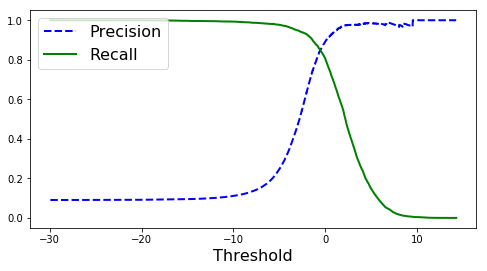

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
#     plt.ylim([0, 1])


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.xlim([-700000, 700000])
plt.show()

Innym sposobem na rozwiązanie **precision/recall tradeoff** jest przeanalizowanie wykresu **precision vs recall**

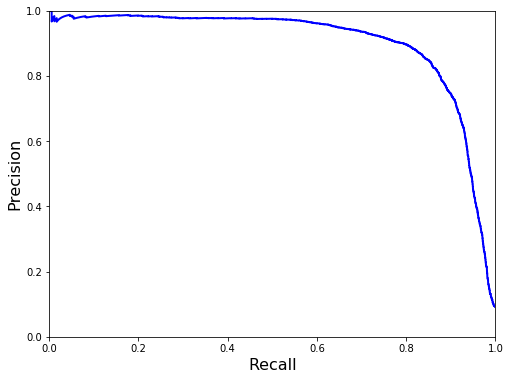

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

 * Widać, że **precision** zaczyna gwałtownie spadać w okolicach 90%. 
 * Prawdopodobnie będziesz chciał wybrać kompromis pomiędzy **precision** i **recall** tuż przed tym spadkiem.
 * Na przykład około 80% **recall**.
 
Załóżmy więc, że zdecydujesz się dążyć do 95% **precision**. Wystarczy nieco powiększyć pierwszy wykres i odczytać, że musisz użyć progu około 5. 

In [37]:
y_train_pred_90 = (y_scores > 2)

In [38]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.972181551976574
0.5325847202727091


Świetnie, masz klasyfikator z dokładnością 90% (lub wystarczająco blisko)! Jak widać, dość łatwo jest utworzyć klasyfikator z praktycznie dowolną precyzją: 
 * wystarczy ustawić odpowiednio wysoki próg i gotowe. 
 
Klasyfikator o wysokiej dokładności nie jest zbyt przydatny, jeśli jego **recall** jest zbyt niskie!

# ROC Curve

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

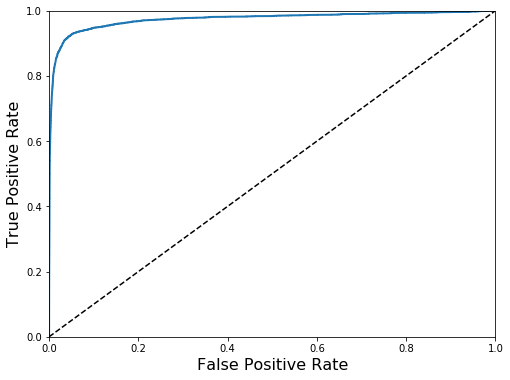

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

*  **Receiver operating characteristic (ROC) ** jest kolejnym powszechnym narzędziem stosowanym w klasyfikatorach binarnych. 
* Jest to bardzo podobne do krzywej **precision/recall curve** ale zamiast opisywać relację między **precision** a **recall** opisuje

 ### sensitivity (recall) vs 1-specificity

gdzie

$$
specificity = \frac{TN}{FP+TN}
$$
$$
recall = \frac{TP}{TP + FN}
$$

* Ponownie jak wcześniej: im wyższe **recall** tym więcej fałszywych alarmów **specificity**.
* Linia przerywana przedstawia krzywą ROC czysto losowego klasyfikatora.
* Dobry klasyfikator daje krzywą jak najdalszą od tej.


### Jednym ze sposobów porównywania klasyfikatorów jest pomiar **area under the curve (AUC)**. 

* Idealny klasyfikator będzie miał ROC AUC równe 1
* podczas gdy klasyfikator czysto losowy będzie miał ROC AUC równe 0.5. 

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9740296398011713

# Zad. 

Nauczmy RandomForestClassifier i porównajmy jego krzywą ROC i wynik ROC AUC z LogisticRegression.

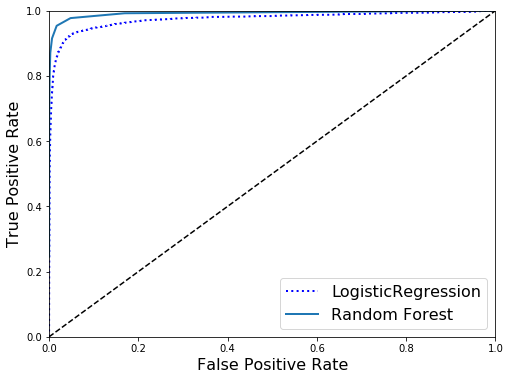

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="LogisticRegression")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()